# 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import seaborn as sns

# plt 폰트 설정 
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 데이터 호출

In [106]:
df = pd.read_csv("C:/Users/dlwlg/Desktop/피처엔지니어링한통합데이터/피처엔지니어링일단다한통합데이터.csv")

In [107]:
# 기준년분기코드 기준으로 전분분기 대비 점포수가 증가한 경우에 1/0 부여하기
df = df.sort_values(['상권_코드_명','기준_년분기_코드'])
df['전분기_점포수'] = df.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
df['점포수 증가'] = (df['유사_업종_점포_수'] > df['전분기_점포수']).astype(int)
# 20242 까지의 점수 합산
df['개업 점수'] = df.groupby('상권_코드_명')['점포수 증가'].cumsum()

# 추출한 변수들 가공 
df['매출_점포비'] = df.groupby(['기준_년분기_코드', '상권_코드_명'])['당월_매출_금액'].transform('sum') / df.groupby(['기준_년분기_코드', '상권_코드_명'])['유사_업종_점포_수'].transform('sum')
df['매출_유동인구비'] = df.groupby(['기준_년분기_코드', '상권_코드_명'])['당월_매출_금액'].transform('sum') / df.groupby(['기준_년분기_코드', '상권_코드_명'])['총_유동인구_수'].transform('sum')
df['업종다양성'] = df.groupby(['기준_년분기_코드', '상권_코드_명'])['서비스_업종_코드_명'].transform('nunique')

# 경쟁강도 지수 계산
df['경쟁강도'] = df.groupby(['기준_년분기_코드', '상권_코드_명'])['유사_업종_점포_수'].transform('sum') / df.groupby(['기준_년분기_코드', '행정동_코드_명'])['유사_업종_점포_수'].transform('sum')

df['프랜차이즈_비율'] = df.groupby(['기준_년분기_코드', '상권_코드_명'])['프랜차이즈_점포_수'].transform('sum') / df.groupby(['기준_년분기_코드', '상권_코드_명'])['유사_업종_점포_수'].transform('sum')
df = df.drop_duplicates()

# 점수 산출

#### 1. PCA 값을 제곱분포로 바꾸고, 0~20 MinMax

In [109]:
# 필요한 컬럼만 선택
features = ['매출_점포비','프랜차이즈_비율','매출_유동인구비','개업 점수','업종다양성']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_selected[features])

In [110]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.9999
각 변수의 설명력 : [[ 9.99999998e-01  2.68606462e-10  5.62101078e-05 -5.00228253e-07
  -1.04131758e-07]]


In [ ]:
# 제곱변환
final_scores = np.square(pca_result)

# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
scaled_data = scaler.fit_transform(final_scores)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': scaled_data.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

       상권_코드_명        포화도_점수
26459  신우어린이공원  2.000000e+01
29467  신우어린이공원  1.806788e+01
27963  신우어린이공원  1.762752e+01
32467  신우어린이공원  1.655242e+01
30965  신우어린이공원  1.526218e+01
...        ...           ...
32646   온수역 1번  7.217190e-11
31545   강남개포시장  5.201570e-11
32573  연신내역 2번  4.411165e-11
26692      응봉산  4.063046e-11
14967  화랑대역 7번  0.000000e+00

[33010 rows x 2 columns]


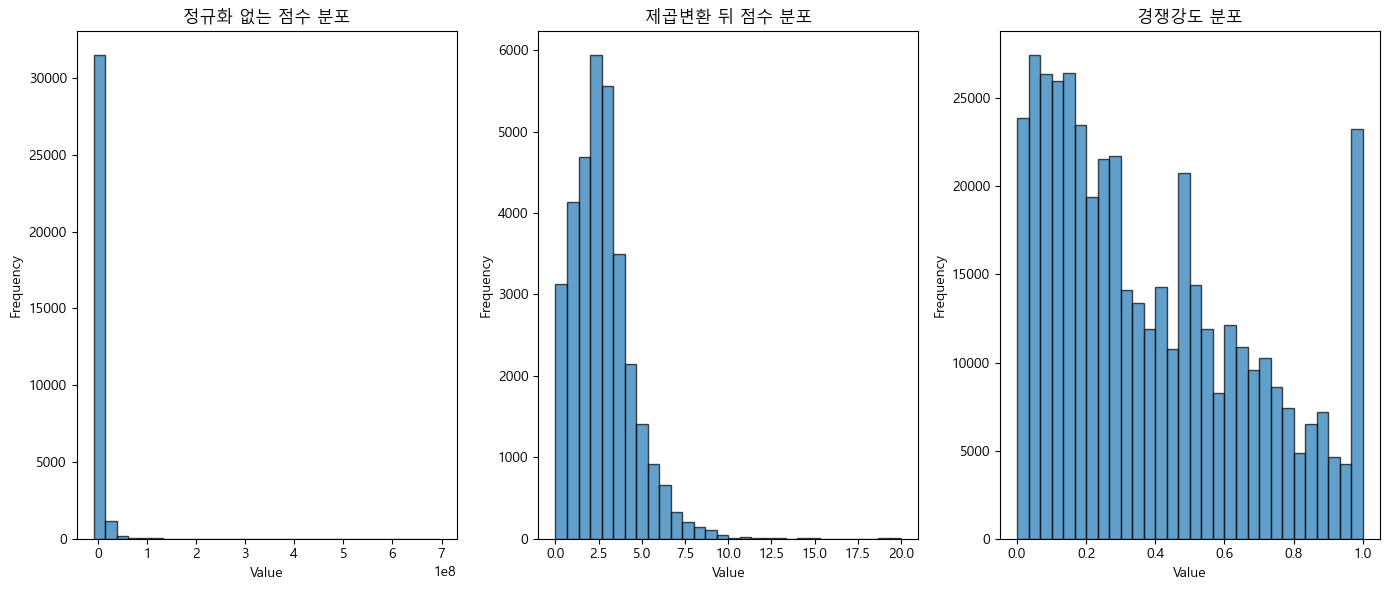

In [112]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# 첫 번째 히스토그램: only PCA
axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("정규화 없는 점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 표준화 뒤 0~20
axes[1].hist(result_df['포화도_점수'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("제곱변환 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 2. PCA 값 표준화 뒤 0~20 MinMax하고 정규분포

In [113]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_selected[features])

In [114]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.9999
각 변수의 설명력 : [[-5.00228253e-07  9.99999998e-01  5.62101078e-05  2.68606462e-10]]


In [115]:
# 표준화
ss = StandardScaler()
scaled_data = ss.fit_transform(pca_result)

# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = scaler.fit_transform(scaled_data)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': final_scores.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

       상권_코드_명        포화도_점수
26459  신우어린이공원  2.000000e+01
29467  신우어린이공원  1.902096e+01
27963  신우어린이공원  1.879059e+01
32467  신우어린이공원  1.821578e+01
30965  신우어린이공원  1.750070e+01
...        ...           ...
17859    청평화시장  6.879167e-07
16359    청평화시장  4.497233e-07
13359    청평화시장  2.625844e-07
10359    청평화시장  1.929697e-07
19360    청평화시장  0.000000e+00

[33010 rows x 2 columns]


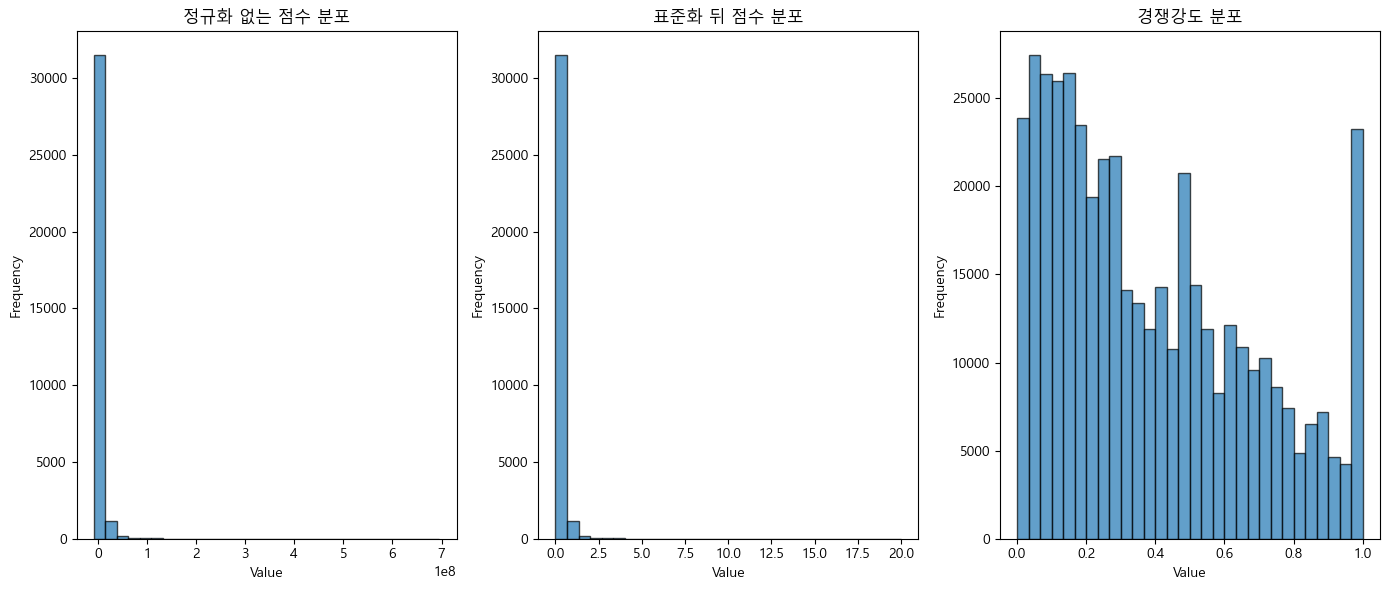

In [116]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# 첫 번째 히스토그램: 0~20
axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("정규화 없는 점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 표준화 뒤 0~20 
axes[1].hist(final_scores, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("표준화 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 4. 변수를 표준화 후 PCA > 0~20 MinMax

In [121]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# 변수 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])
    
# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_features)

In [122]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.2761
각 변수의 설명력 : [[ 0.71167257 -0.69837227 -0.07036872  0.02909595]]


In [123]:
# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
scaled_data = scaler.fit_transform(pca_result)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': scaled_data.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

                      상권_코드_명     포화도_점수
32798              종로·청계 관광특구  20.000000
32015  명동 남대문 북창동 다동 무교동 관광특구  19.923403
31295              종로·청계 관광특구  19.849607
30510  명동 남대문 북창동 다동 무교동 관광특구  19.779858
31799                     노원역  19.756514
...                       ...        ...
30965                 신우어린이공원   2.140411
32467                 신우어린이공원   1.528047
27963                 신우어린이공원   1.035687
29467                 신우어린이공원   0.838571
26459                 신우어린이공원   0.000000

[33010 rows x 2 columns]


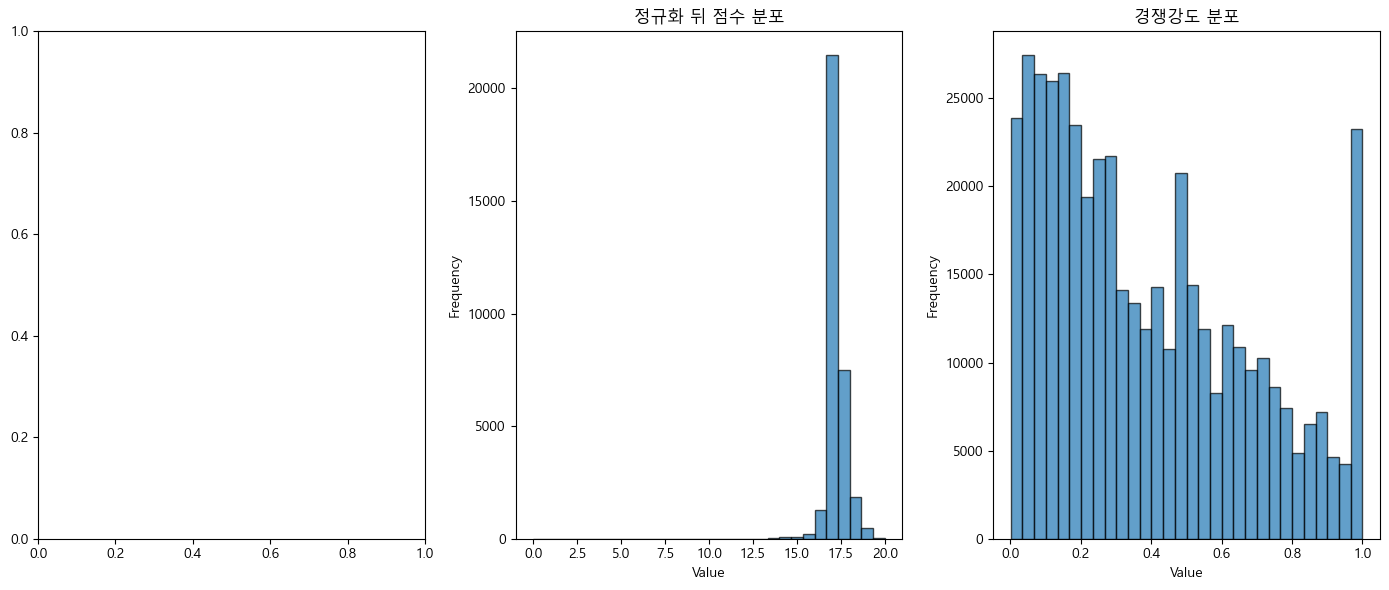

In [124]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# # 첫 번째 히스토그램: 0~20
# axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
# axes[0].set_title("정규화 없는 점수 분포")
# axes[0].set_xlabel("Value")
# axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 0~20 뒤 정규화 
axes[1].hist(scaled_data, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("정규화 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 5. 변수 로그정규화, 표준화 > 주성분 추가 PCA

In [216]:
# 필요한 컬럼만 선택
# features = ['매출_점포비','매출_유동인구비','프랜차이즈_비율','개업 점수','업종다양성']
features = ['매출_점포비','프랜차이즈_비율','개업 점수','업종다양성']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# 로그 정규화 
for feature in features:
    df_pca = np.log1p(df_selected[features])
    
# 변수 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])
    
# PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)

In [217]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.4533
주성분 2: 설명된 분산 비율 = 0.2617
각 변수의 설명력 : [[-0.2098512   0.10828608  0.68257291  0.69161465]
 [ 0.62990568  0.7750821   0.03534688  0.03488798]]


In [218]:
# 동적으로 주성분 컬럼명 생성
pc_columns = [f'PC{i+1}' for i in range(n_components)]

# PCA 결과를 DataFrame으로 변환
test_pca_df = pd.DataFrame(pca_result, columns=pc_columns)

# 원래 변수와 주성분 간의 상관관계 계산 (동적으로 처리)
correlation_results = {}
for pc in pc_columns:
    correlation_matrix = pd.DataFrame(scaled_features).corrwith(test_pca_df[pc])
    correlation_results[pc] = correlation_matrix
    print(f"Correlation with {pc}:\n{correlation_matrix}\n")

# 설명된 분산 비율
explained_variance = np.array(pca.explained_variance_ratio_)

# 가중치 계산 (합이 1이 되도록 정규화)
weights = explained_variance / explained_variance.sum()

# 최종 점수 계산 (n_components 개수에 맞게 자동 처리)
test_pca_df['Final_Score'] = test_pca_df[pc_columns].dot(weights)

# 결과 확인
print(test_pca_df)

Correlation with PC1:
0   -0.282581
1    0.145816
2    0.919138
3    0.931313
dtype: float64

Correlation with PC2:
0    0.644469
1    0.793002
2    0.036164
3    0.035695
dtype: float64

            PC1       PC2  Final_Score
0     -0.968538  0.363761    -0.480917
1     -0.916900 -0.375430    -0.718722
2      0.688339  1.237006     0.889150
3     -0.270956  0.156060    -0.114669
4     -0.908755  1.802278     0.083481
...         ...       ...          ...
33005 -0.775640 -0.647156    -0.728615
33006  1.775518 -0.310195     1.012149
33007  0.236525  0.802863     0.443804
33008 -0.811048  3.933791     0.925559
33009  0.446689  0.052564     0.302439

[33010 rows x 3 columns]


In [219]:
# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
scaled_data = scaler.fit_transform(test_pca_df[['Final_Score']])

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '기준_년분기_코드': df_selected['기준_년분기_코드'],
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': scaled_data.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

       기준_년분기_코드                 상권_코드_명     포화도_점수
32015      20242  명동 남대문 북창동 다동 무교동 관광특구  20.000000
32798      20242              종로·청계 관광특구  19.771486
30510      20241  명동 남대문 북창동 다동 무교동 관광특구  19.457777
31799      20242                     노원역  19.208907
32756      20242                  장안동사거리  19.185620
...          ...                     ...        ...
1662       20192                  구로구민회관   0.000376
28398      20233        평화시장(통일상가, 동화상가)   0.000219
934        20191        신림중앙시장(조원동 펭귄시장)   0.000057
3287       20193                  논현목련공원   0.000001
31400      20241        평화시장(통일상가, 동화상가)   0.000000

[33010 rows x 3 columns]


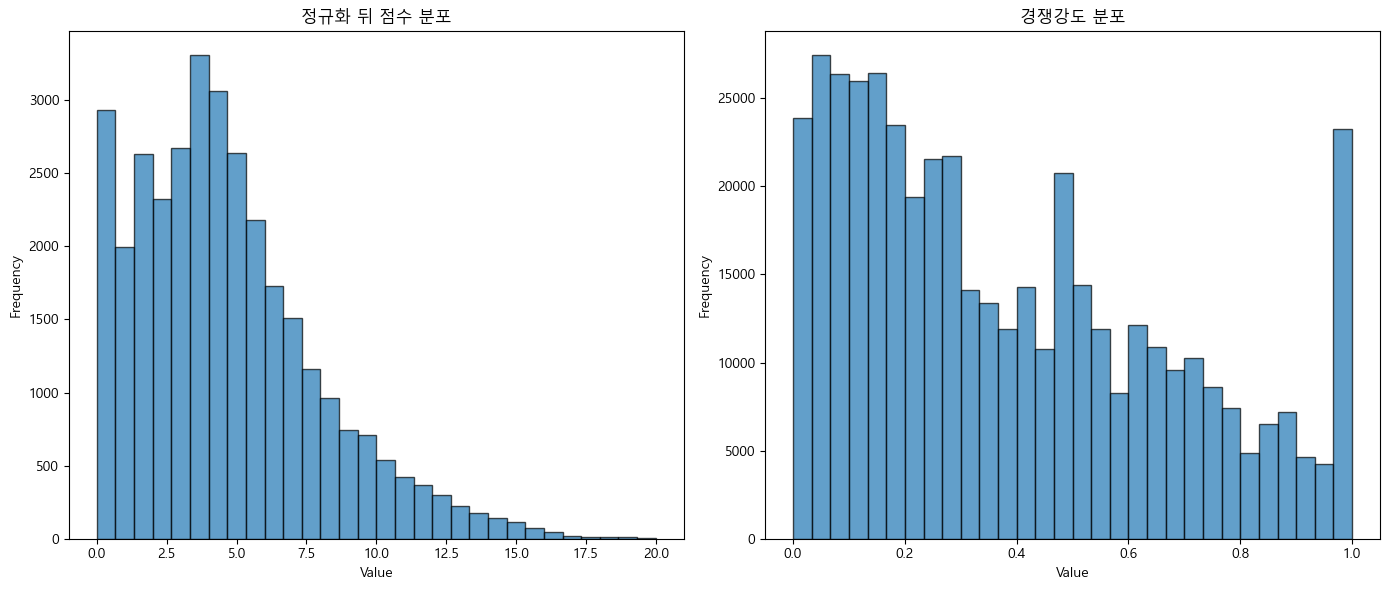

In [220]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# 두 번째 히스토그램: 0~20 뒤 정규화 
axes[0].hist(scaled_data, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("정규화 뒤 점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[1].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("경쟁강도 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

경쟁강도와 포화도_점수의 상관계수: 0.4508614888115822


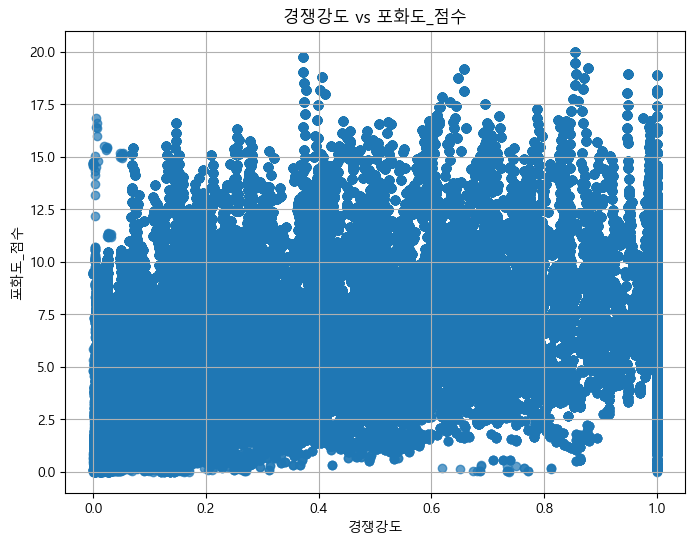

In [221]:
# 두 데이터프레임에서 필요한 열만 선택하여 병합 (inner join)
merged_df = pd.merge(
    df[['기준_년분기_코드', '상권_코드_명', '경쟁강도']],
    result_df[['기준_년분기_코드', '상권_코드_명', '포화도_점수']],
    on=['기준_년분기_코드', '상권_코드_명'],
    how='inner'
)

# 두 변수의 상관계수 계산
correlation = merged_df['경쟁강도'].corr(merged_df['포화도_점수'])
print("경쟁강도와 포화도_점수의 상관계수:", correlation)

# 산점도(scatter plot)로 시각화
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['경쟁강도'], merged_df['포화도_점수'], alpha=0.7)
plt.xlabel('경쟁강도')
plt.ylabel('포화도_점수')
plt.title('경쟁강도 vs 포화도_점수')
plt.grid(True)
plt.show()


In [222]:
# result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/듀듀듀듀.csv", encoding='cp949')